# Homework 1 Solution

In [92]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pandas_datareader as web
import scipy.optimize as opt
from scipy.stats import norm

### Black's formula and implied volatility

In [93]:
def blackPremium(discountFactor, forward, strike, timeToExpiration, isCall, sigma):
    with np.errstate(divide = 'ignore'): # ignore warning: divide by zero
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        logMoneyness = np.log(np.divide(forward, strike))
        d1 = (0.0 if logMoneyness == 0.0 else np.divide(logMoneyness, terminalVolatility)) + 0.5 * terminalVolatility
        d2 = (0.0 if logMoneyness == 0.0 else np.divide(logMoneyness, terminalVolatility)) - 0.5 * terminalVolatility
        forwardCallPremium = forward * norm.cdf(d1) - strike * norm.cdf(d2)
        if isCall:
            return discountFactor * forwardCallPremium
        else:
            return discountFactor * (forwardCallPremium - (forward - strike))

In [94]:
def blackVolatility(discountFactor, forward, strike, timeToExpiration, isCall, premium):
    def getPremium(sigma):
        return blackPremium(discountFactor, forward, strike, timeToExpiration, isCall, sigma)
    if np.isnan(premium):
        return np.nan
    elif premium <= getPremium(0.0):
        return 0.0
    elif premium >= getPremium(np.inf):
        return np.inf
    low = 0.0
    high = 1.0
    while (getPremium(high) < premium):
        high = 2.0 * high
    while (high - low > 1.0e-8):
        mid = 0.5 * (low + high)
        if (getPremium(mid) >= premium):
            high = mid
        else:
            low = mid
    return 0.5 * (low + high)

### Import data

In [95]:
spxOptionsData = pd.read_csv('SPX_Options_August1-7_2024.csv')
# convert columns to date type
spxOptionsData['As of Date'] = pd.to_datetime(spxOptionsData['As of Date']).apply(lambda dt: dt.date())
spxOptionsData['Expiration Date'] = pd.to_datetime(spxOptionsData['Expiration Date']).apply(lambda dt: dt.date())
print(spxOptionsData[0:5])

   As of Date  Underlying Price Expiration Date  Time to Expiration  \
0  2024-08-01       5431.320512      2024-08-02            0.003968   
1  2024-08-01       5431.320512      2024-08-02            0.003968   
2  2024-08-01       5431.320512      2024-08-02            0.003968   
3  2024-08-01       5431.320512      2024-08-02            0.003968   
4  2024-08-01       5431.320512      2024-08-02            0.003968   

   Strike Price   Put Premium  Call Premium  
0           200  1.503819e-08   5231.341529  
1           205  1.641890e-08   5226.343864  
2           210  2.205989e-08   5221.346198  
3           215  4.306468e-08   5216.348533  
4           220  9.744485e-08   5211.350868  


In [96]:
spxSpotPrices =\
    web.DataReader(
        'SP500',
        'fred',
        start = pd.to_datetime('2024-08-01').date(),
        end = pd.to_datetime('2025-03-31').date())

## Problem 1

### Calculate discount factors and forward prices

In [97]:
def estimateDiscountFactor(row):
    avgK = row['Strike Price'].mean()
    avgO = (row['Call Premium'] - row['Put Premium']).mean()
    avgKK = (row['Strike Price'] ** 2).mean()
    avgKO = (row['Strike Price'] * (row['Call Premium'] - row['Put Premium'])).mean()
    return (avgKO - avgK * avgO) / (avgK ** 2 - avgKK)
def estimateForwardPrice(row):
    avgK = row['Strike Price'].mean()
    avgO = (row['Call Premium'] - row['Put Premium']).mean()
    avgKK = (row['Strike Price'] ** 2).mean()
    avgKO = (row['Strike Price'] * (row['Call Premium'] - row['Put Premium'])).mean()
    return (avgK * avgKO - avgKK * avgO) / (avgKO - avgK * avgO)
forwardTermStructures =\
    pd.merge(
        pd.DataFrame(
            spxOptionsData.groupby(['As of Date', 'Expiration Date']).apply(estimateDiscountFactor),
            columns = ['Discount Factor']).reset_index(),
        pd.DataFrame(
            spxOptionsData.groupby(['As of Date', 'Expiration Date']).apply(estimateForwardPrice),
            columns = ['Forward Price']).reset_index(),
        on = ['As of Date', 'Expiration Date'])

### Plot discount and forward term structures as of 8/1/2024

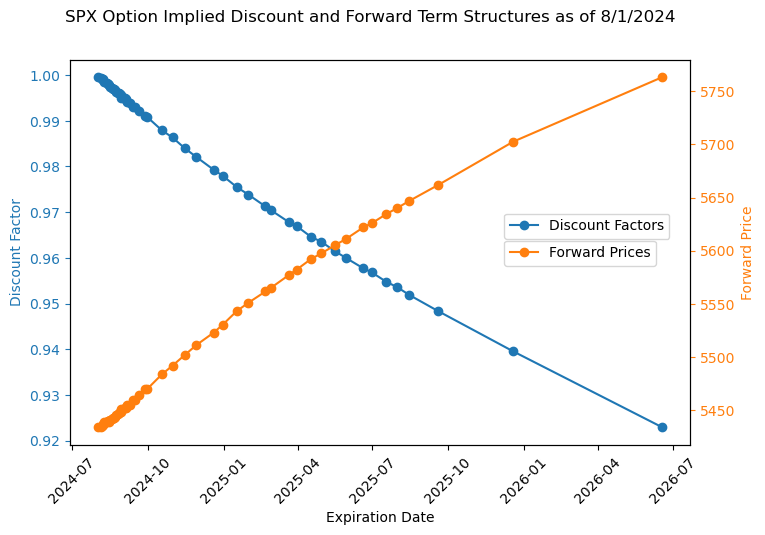

In [98]:
(fig, ax) = plt.subplots(1, 1, figsize = (8, 5))
fig.suptitle('SPX Option Implied Discount and Forward Term Structures as of 8/1/2024')
ax.plot(
    forwardTermStructures.loc[
        (forwardTermStructures['As of Date'] == pd.to_datetime('2024-08-01').date()), 'Expiration Date'],
    forwardTermStructures.loc[
        (forwardTermStructures['As of Date'] == pd.to_datetime('2024-08-01').date()), 'Discount Factor'],
    label = 'Discount Factors',
    color = 'C0',
    marker = 'o')
ax.set_xlabel('Expiration Date')
ax.set_ylabel('Discount Factor', color = 'C0')
ax.tick_params(axis = "x", rotation = 45)
ax.tick_params(axis = 'y', color = 'C0', labelcolor = 'C0')

ax2 = ax.twinx()
ax2.plot(
    forwardTermStructures.loc[
        (forwardTermStructures['As of Date'] == pd.to_datetime('2024-08-01').date()), 'Expiration Date'],
    forwardTermStructures.loc[
        (forwardTermStructures['As of Date'] == pd.to_datetime('2024-08-01').date()), 'Forward Price'],
    label = 'Forward Prices',
    color = 'C1',
    marker = 'o')
ax2.set_ylabel('Forward Price', color = 'C1')
ax2.tick_params(axis = 'y', color = 'C1', labelcolor = 'C1')

#ax.table(
#    cellText = forwardTermStructures.loc[
#        (forwardTermStructures['As of Date'] == pd.to_datetime('2024-08-01').date()),
#        ['Expiration Date', 'Discount Factor', 'Forward Price']].values,
#    colLabels = ['Expiration Date', 'Discount Factor', 'Forward Price'],
#    colColours = ['none', 'C0', 'C1'],
#    cellLoc = 'center',
#    bbox = [-1.0, -0.5, 0.8, 2.0])
ax.legend(loc = (0.7, 0.535))
ax2.legend(loc = (0.7, 0.465))
plt.savefig('ForwardTermStructures.pdf', bbox_inches = 'tight')
plt.show(fig)

### Merge term structures into option prices

In [99]:
spxOptionsData2 = pd.merge(forwardTermStructures, spxOptionsData, on = ['As of Date', 'Expiration Date'])

## Problem 2: volatility smile calculation using incorrect discount factor and forward price

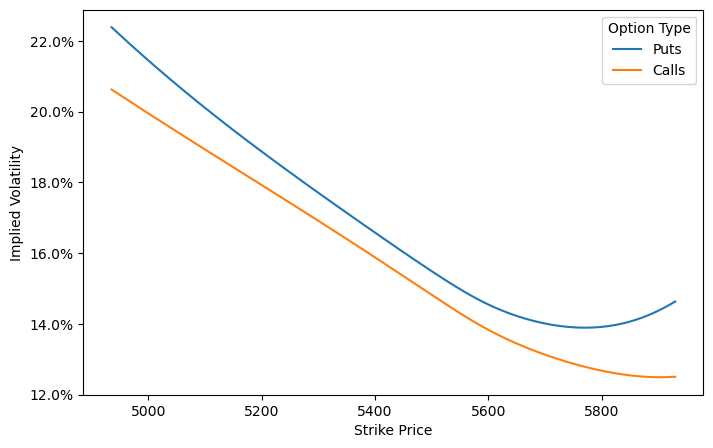

In [100]:
failedImpliedVolatilityFilter =\
    (spxOptionsData2['As of Date'] == pd.to_datetime('2024-08-01').date()) &\
    (spxOptionsData2['Expiration Date'] == pd.to_datetime('2024-09-20').date()) &\
    ((spxOptionsData2['Strike Price'] - spxOptionsData2['Underlying Price']).abs() < 500)
spxOptionsData2['Put Implied Volatility (incorrect)'] =\
    spxOptionsData2.loc[failedImpliedVolatilityFilter, :].apply(
        lambda row:
            blackVolatility(
                0.993,
                row['Underlying Price'] / 0.993,
                row['Strike Price'],
                row['Time to Expiration'],
                False,
                row['Put Premium']),
        axis = 1)
spxOptionsData2['Call Implied Volatility (incorrect)'] =\
    spxOptionsData2.loc[failedImpliedVolatilityFilter, :].apply(
        lambda row:
            blackVolatility(
                0.993,
                row['Underlying Price'] / 0.993,
                row['Strike Price'],
                row['Time to Expiration'],
                True,
                row['Call Premium']),
        axis = 1)
(fig, ax) = plt.subplots(1, 1, figsize = (8, 5))
#fig.suptitle('SPX Volatility Smile for 9/20/2024 Expiration as of 8/1/2024')
ax.plot(
    spxOptionsData2.loc[failedImpliedVolatilityFilter, 'Strike Price'],
    spxOptionsData2.loc[failedImpliedVolatilityFilter, 'Put Implied Volatility (incorrect)'],
    label = 'Puts')
ax.plot(
    spxOptionsData2.loc[failedImpliedVolatilityFilter, 'Strike Price'],
    spxOptionsData2.loc[failedImpliedVolatilityFilter, 'Call Implied Volatility (incorrect)'],
    label = 'Calls')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied Volatility')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1.0))
ax.legend(title = 'Option Type')
plt.savefig('FailedVolatilitySmiles.pdf', bbox_inches = 'tight')
plt.show(fig)

## Problem 3

### Calculate realized volatility

In [101]:
realizedVolatility =\
    np.log(spxSpotPrices['SP500'] / spxSpotPrices['SP500'].shift()).std() * np.sqrt(252.0)
print(f'Realized volatility is: {realizedVolatility : .2%}')

Realized volatility is:  14.98%


### Calculate implied volatility

In [102]:
impliedVolatilityFilter =\
    (spxOptionsData2['As of Date'] == pd.to_datetime('2024-08-01').date()) &\
    (spxOptionsData2['Expiration Date'] == pd.to_datetime('2024-09-20').date())
spxOptionsData2['Implied Volatility'] =\
    spxOptionsData2.loc[impliedVolatilityFilter, :].apply(
        lambda row:
            blackVolatility(
                row['Discount Factor'],
                row['Forward Price'],
                row['Strike Price'],
                row['Time to Expiration'],
                (row['Strike Price'] > row['Forward Price']), # use OTM (forward) option (but doesn't matter)
                (row['Call Premium'] if row['Strike Price'] > row['Forward Price'] else row['Put Premium'])),
        axis = 1)

### Volatility plot

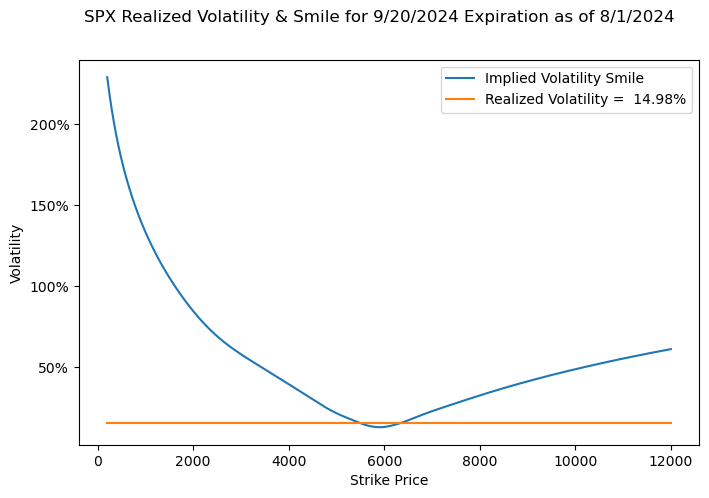

In [103]:
(fig, ax) = plt.subplots(1, 1, figsize = (8, 5))
fig.suptitle('SPX Realized Volatility & Smile for 9/20/2024 Expiration as of 8/1/2024')
ax.plot(
    spxOptionsData2.loc[impliedVolatilityFilter, 'Strike Price'],
    spxOptionsData2.loc[impliedVolatilityFilter, 'Implied Volatility'],
    label = 'Implied Volatility Smile')
ax.plot(
    [
        spxOptionsData2.loc[impliedVolatilityFilter, 'Strike Price'].min(),
        spxOptionsData2.loc[impliedVolatilityFilter, 'Strike Price'].max()],
    [realizedVolatility, realizedVolatility],
    label = f'Realized Volatility = {realizedVolatility : .2%}')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Volatility')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1.0))
plt.savefig('VolatilitySmile.pdf', bbox_inches = 'tight')
plt.show(fig)

In [104]:
#print(spxOptionsData2.loc[impliedVolatilityFilter, 'Strike Price'][350:400])

## Problem 4

In [105]:
strike = 6000

spxSpotPrices2 =\
    web.DataReader(
        'SP500',
        'fred',
        start = pd.to_datetime('2024-08-01').date(),
        end = pd.to_datetime('2024-08-07').date())
S = spxSpotPrices2['SP500']

option_filter =\
    (spxOptionsData2['As of Date'] >= pd.to_datetime('2024-08-01').date()) &\
    (spxOptionsData2['As of Date'] <= pd.to_datetime('2024-08-07').date()) &\
    (spxOptionsData2['Expiration Date'] == pd.to_datetime('2024-09-20').date()) &\
    (spxOptionsData2['Strike Price'] == strike)
option_data = spxOptionsData2[option_filter]
C = option_data['Call Premium']
tau = option_data['Time to Expiration']

In [106]:
print(S)
print(C)

DATE
2024-08-01    5446.68
2024-08-02    5346.56
2024-08-05    5186.33
2024-08-06    5240.03
2024-08-07    5199.50
Name: SP500, dtype: float64
67268     2.545157
197123    1.615530
326978    2.271642
456833    0.937330
584327    1.050000
Name: Call Premium, dtype: float64


In [107]:
sigma1 = np.log(S/S.shift()).std() * np.sqrt(252.0)
print(sigma1)

0.2745201575678818


In [108]:
option_filter2 =\
    (spxOptionsData2['As of Date'] == pd.to_datetime('2024-08-01').date()) &\
    (spxOptionsData2['Expiration Date'] == pd.to_datetime('2024-09-20').date()) &\
    (spxOptionsData2['Strike Price'] == strike)
option_data2 = spxOptionsData2[option_filter2]

sigma2 = option_data2['Implied Volatility'].values[0]
print(sigma2)

discountFactor = option_data2['Discount Factor'].values[0]
print(discountFactor)
forward = option_data2['Forward Price'].values[0]
print(forward)

r = -np.log(discountFactor)/tau.values[0]
q = -np.log(forward*discountFactor/S.values[0])/tau.values[0]
print(r,q)

0.12795205786824226
0.9920532208059578
5464.146833201305
0.05744536653865319 0.034392795288956605


In [109]:
def blackDelta(discountFactor, forward, strike, timeToExpiration, isCall, sigma):
    with np.errstate(divide = 'ignore'): # ignore warning: divide by zero
        terminalVolatility = sigma * np.sqrt(timeToExpiration)
        logMoneyness = np.log(np.divide(forward, strike))
        d1 = (0.0 if logMoneyness == 0.0 else np.divide(logMoneyness, terminalVolatility)) + 0.5 * terminalVolatility
        #d2 = (0.0 if logMoneyness == 0.0 else np.divide(logMoneyness, terminalVolatility)) - 0.5 * terminalVolatility
        deltaCall = norm.cdf(d1)
        deltaPut = -norm.cdf(-d1)
        if isCall:
            return deltaCall
        else:
            return deltaPut

[-18.58948366860842, -23.813568539383922, 5.728571710585886, -4.051336552939594]
[-1.7170710859514169, -2.1100838421166315, 1.3930444830412072, -0.19370448450214428]
[0.19399734172042327, 0.14406237023685137, 0.08273122900012614, 0.0958442514838504]
[0.02631010103170036, 0.00904651528518406, 0.001110128969413706, 0.0019676689073177293]
[-99.3765899447274, -159.50025518937863, 54.407875232611495, -39.81479532633992]
[-0.9296274737683579, 0.6561121358912843, -1.3343119719348828, 0.11267024825406036]


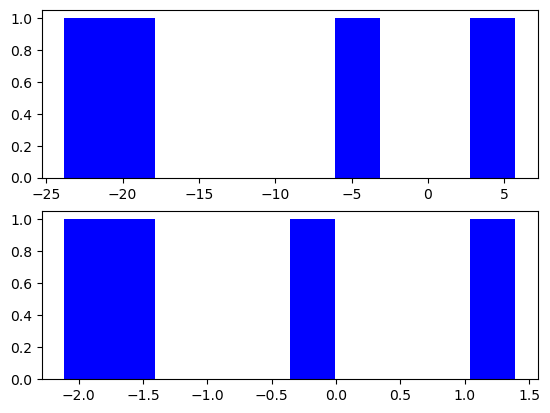

In [110]:
ret1 = []
ret2 = []
delta1 = []
delta2 = []
S_ret = []
C_ret = []
wealth1 = [C.values[0]]
wealth2 = [C.values[0]]
cash1 = 0
cash2 = 0
for i in range(len(S.values)-1):
    cur_forw = S.values[i]*np.exp(r*tau.values[i]-q*tau.values[i])
    cur_disc = np.exp(-r*tau.values[i])
    delta1.append(blackDelta(cur_disc, cur_forw, strike, tau.values[i], 'True', sigma1))
    delta2.append(blackDelta(cur_disc, cur_forw, strike, tau.values[i], 'True', sigma2))
    cash1 = wealth1[-1] - delta1[-1]*S.values[i]
    cash2 = wealth2[-1] - delta2[-1]*S.values[i]
    S_ret.append(S.values[i+1]-S.values[i] + (np.exp(q/252)-1)*S.values[i])
    C_ret.append(C.values[i+1]-C.values[i])
    ret1.append(delta1[-1]*S_ret[-1] - C_ret[-1] + cash1*(np.exp(r/252)-1))
    ret2.append(delta2[-1]*S_ret[-1] - C_ret[-1] + cash2*(np.exp(r/252)-1))
    wealth1.append(wealth1[-1]+delta1[-1]*S_ret[-1] + cash1*(np.exp(r/252)-1))
    wealth2.append(wealth2[-1]+delta2[-1]*S_ret[-1] + cash2*(np.exp(r/252)-1))

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(ret1, color='blue')
ax2.hist(ret2, color='blue')
    
print(ret1)
print(ret2)

print(delta1)
print(delta2)

print(S_ret)
print(C_ret)